In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import seaborn as sn
import pandas as pd

In [0]:
BATCH_SIZE = 96

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)



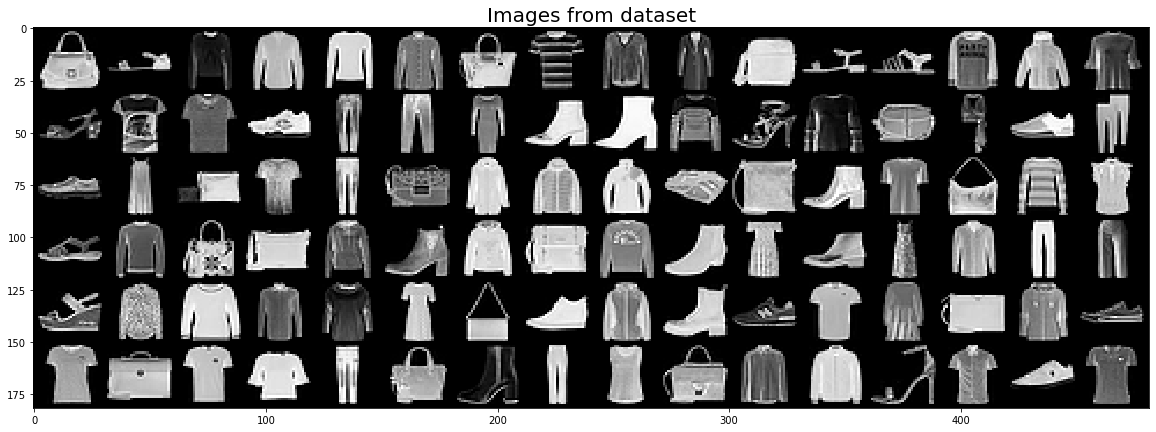

In [5]:
#Function showing images
def image_show(image):
    npimg = image.numpy()
    plt.figure(figsize = (20,7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='nearest',\
               aspect='auto')
    plt.title("Images from dataset", fontsize=20)
    plt.show()
    
#Retrieve random pics from data
dataiterator = iter(trainloader)
images, labels = dataiterator.next()

#Show images
image_show(torchvision.utils.make_grid(images,nrow=16))

In [6]:
#describe dimensions of data
for images, labels in trainloader:
  print("Dimensions:\nBatchsize: {} | Depth: {} | Height: {} | Width: {}"\
        .format(images.shape[0], images.shape[1],\
                images.shape[2], images.shape[3]))
  break

Dimensions:
Batchsize: 96 | Depth: 1 | Height: 28 | Width: 28


Lay-out of network:
CONV -> ReLU -> CONV -> ReLU -> MaxPool -> DropOut -> CONV
-> ReLU -> MaxPool -> Linear -> ReLU -> Linear

* in_channels: referer til dybden. F.eks. 3 når du har RBG og 1 når du har grått
* out_channels: Hvor mange filtere
* stride : hvordan filtere beveger seg
* max pooling: se https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks
* average pooling: https://www.quora.com/What-is-the-benefit-of-using-average-pooling-rather-than-max-pooling
* Calculate dimension after conv:
    ((W - F + 2P)/S)+1

In [0]:
class PassionForFashion(nn.Module):
    def __init__(self):
        super(PassionForFashion, self).__init__()

        #first feature
        self.feature0 = nn.Sequential(
            
          #first conv layer
          nn.Conv2d(1,8,3), #in_channel = 1, out_channel = 3, kernel = 3
          #input: BATCH_SIZE x 1 x 28 x 28
          #output: BATCH_SIZE x 8 x 26 x 26 

          #first relu
          nn.ReLU()
          #ReLU does not change size of input (input = output)
        )

        #second feature
        self.feature1 = nn.Sequential(
            
          #second conv layer
          nn.Conv2d(8,32,3), #in_channel = 3, out_channel = 12, kernel = 4
          #input: BATCH_SIZE x 8 x 26 x 26 
          #output: BATCH_SIZE x 32 x 24 x 24 

          #second relu
          nn.ReLU(),

          #first pooling layer
          nn.MaxPool2d(2,2), #kernel = 2, stride = 2
          #input: BATCH_SIZE x 32 x 24 x 24 
          #output: BATCH_SIZE x 32 x 12 x 12
          
          #Max pooling is 
          #done by applying a max filter to 
          #(usually) non-overlapping subregions of the 
          #initial representation.

          #Helps with:
          # - overfitting
          # - complexity

          #dropout layer
          nn.Dropout2d()
          #Randomly zero out entire channels. Each channel will be
          #zeroed out independently on every forward call with 
          #probability p using samples from a Bernoulli distribution.
          #input shape = output shape
        )

        #third feature
        self.feature2 = nn.Sequential(
          #third conv layer
          nn.Conv2d(32,16,3), #in_channel = 12, out_channel = 6, kernel = 3
          #input = BATCH_SIZE x 32 x 12 x 12
          #output = BATCH_SIZE x 16 x 10 x 10
          
          #third relu
          nn.ReLU(),

          #second pool layer
          nn.MaxPool2d(2,2)#kernel = 2, stride = 2
          #input = BATCH_SIZE x 16 x 10 x 10
          #output = BATCH_SIZE x 16 x 5 x 5
        )

        #classifier
        self.classifier = nn.Sequential(
            
            nn.Linear(400, 160), 
            #in = BATCH_SIZE x 400
            #out = what your heart desires
            nn.ReLU(),
            nn.Linear(160,10)
        )

    #feeds forward in CNN
    def forward(self, x):
        x = self.feature0(x)
        x = self.feature1(x)
        x = self.feature2(x)
        #Flatten tensor before going to linear
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [0]:
learning_rate = 0.002
epochs = 6

#use cuda if available, else cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PassionForFashion()
model = model.to(device)

#criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def accuracy(logits,labels,BATCH_SIZE):
  _,pred = torch.max(logits,1)
  corrects = (pred == labels).sum().item()
  accuracy = (100.0 * corrects)/BATCH_SIZE
  return accuracy

In [0]:
#trainer for network
for epoch in range(epochs):
  run_loss = 0.0
  train_acu = 0.0
  

  model = model.train()

  #enumerate tensors with inputs and labels
  for i, data in enumerate(trainloader):
    inputs,labels = data
    
    #send to device
    inputs = inputs.to(device)
    labels = labels.to(device)

    #forward, loss, backpropagation
    logits = model(inputs)
    loss = criterion(logits,labels)
    optimizer.zero_grad()
    loss.backward()
    
    #optimize model parameters
    optimizer.step()

    run_loss += loss.item()
    train_acu += accuracy(logits,labels,BATCH_SIZE)
    

  model.eval()
  print("Epoch: {0} | Loss: {1:.2f} | Training Accuracy: {2:.2f}%".format(epoch, run_loss/(i), train_acu/i))

#Epoch: 0 | Loss: 0.62 | Training Accuracy: 77.46%
#Epoch: 1 | Loss: 0.39 | Training Accuracy: 86.24%
#Epoch: 2 | Loss: 0.34 | Training Accuracy: 87.83%
#Epoch: 3 | Loss: 0.31 | Training Accuracy: 88.77%
#Epoch: 4 | Loss: 0.29 | Training Accuracy: 89.60%
#Epoch: 5 | Loss: 0.27 | Training Accuracy: 90.04%

#BEST RESULT FROM: Epochs = 6; Learning rate = 0.002; Batch size = 96
#Different hyperparameters did not matter much. I think the most important
#factor is how your network is designed. 

In [0]:
#FUNCTION PRIMARILY USED FOR TESTING DIFFERENT HYPERPARAMETERS

#def trainer(num_epochs, learning_rate, nnModel, acc = "yes"):
#  print("Number of epochs: {} | Learning rate: {} | Batch size: {}".\
#        format(num_epochs, learning_rate, BATCH_SIZE))
#  
#  run_loss = 0.0
#  train_acu = 0.0
#
#  for epoch in range(num_epochs):
#    run_loss = 0.0
#    train_acu = 0.0
#    
#    model = nnModel.train()
#
#    #enumerate tensors with inputs and labels
#    for i, data in enumerate(trainloader):
#      inputs,labels = data
#      
#      #send to device
#      inputs = inputs.to(device)
#      labels = labels.to(device)
#
#      #forward, loss, backpropagation
#      logits = model(inputs)
#      loss = criterion(logits,labels)
#      optimizer.zero_grad()
#      loss.backward()
#      
#      #optimize model parameters
#      optimizer.step()
#
#      run_loss += loss.item()
#
#      if acc == "yes":
#        train_acu += accuracy(logits,labels,BATCH_SIZE)
#      
#
#    model.eval()
#    print("Epoch: {0} | Loss: {1:.2f} | Training Accuracy: {2:.2f}%".format(epoch, run_loss/(i), train_acu/i))
#

In [0]:
#TESTING DIFFERENT HYPERPARAMETERS:
#BEST RESULT FROM: Epochs = 6; Learning rate = 0.002; Batch size = 96

#epochs = [i for i in range(5,7)]
#rates = [0.003, 0.002, 0.001]
#batches = [32,96,192]
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#
#import torch.optim as optim
#
##criterion and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#
#for BATCH_SIZE in batches:
#  ## transformations
#  transform = transforms.Compose(
#      [transforms.ToTensor()])
#
#  ## download and load training dataset
#  trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
#                                          download=True, transform=transform)
#
#  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
#                                            shuffle=True, num_workers=2)
#
#  ## download and load testing dataset
#  testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
#                                        download=True, transform=transform)
#  testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
#                                          shuffle=False, num_workers=2)
#  for nr_epochs in epochs:
#    for learning_rate in rates:
#      model = PassionForFashion()
#      model = model.to(device)
#      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#      trainer(nr_epochs, learning_rate, model, acc = "yes")

In [0]:
#Mount driver, this enables us to save model
#in Google Colab

#drive.mount('/content/drive')

#PATH ="./saved_model.pth"
#torch.save(model.state_dict(), PATH)

#model = PassionForFashion()
#model.load_state_dict(torch.load(PATH))
#model.eval()

#filed saved to:
#!ls

In [37]:
#LOAD MODEL:
#PATH ="./saved_model.pth"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = PassionForFashion()
#model.load_state_dict(torch.load(PATH))
#model = model.to(device)

#model.eval()

#Test our trained network
test_acc = 0.0

#no_grad reduces memory usage, also no backprop
with torch.no_grad():
  for i, data in enumerate(testloader):
      inputs,labels = data
      
      #send to device
      inputs = inputs.to(device)
      labels = labels.to(device)

      test_preds = model(inputs)
      test_acc += accuracy(test_preds, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f %%'%(test_acc/i))

#Result: 89.68%


Test Accuracy: 89.68 %


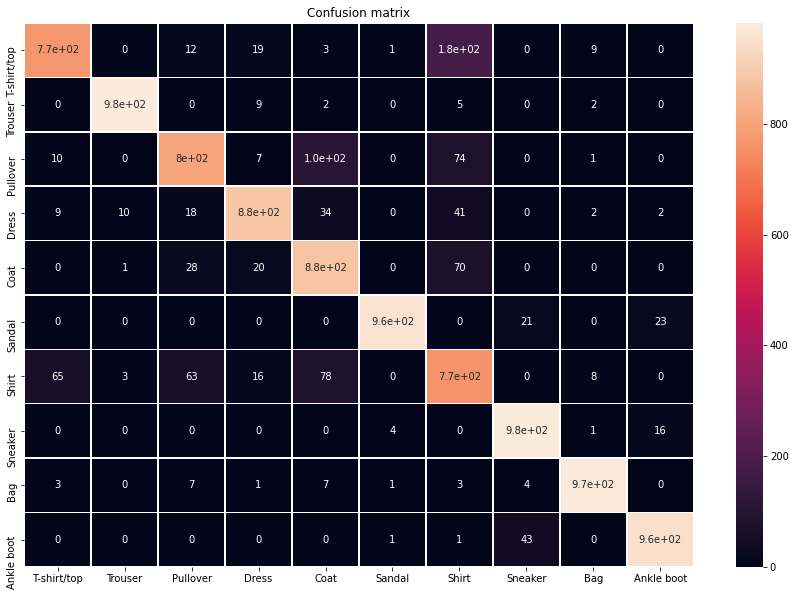

In [57]:
#MAKE CONFUSION MATRIX

label_classes = ["T-shirt/top",	"Trouser",	"Pullover",	"Dress",\
           "Coat",	"Sandal",	"Shirt",	"Sneaker",	"Bag",	"Ankle boot"]

all_preds = torch.tensor([])

with torch.no_grad():
  for i, data in enumerate(testloader):
    inputs,labels = data
    preds = model(inputs)
    all_preds = torch.cat((all_preds, preds),dim=0)

con_tensor = torch.stack((testset.targets,all_preds.argmax(dim=1)),dim=1)

#10x10 tensor with zeros
confusion_matrix = torch.zeros(10,10, dtype=torch.int64)

#for each true label, predicted pair
for pair in con_tensor:
    true, pred = pair.tolist()
    confusion_matrix[true, pred] += 1

cmt_arr = confusion_matrix.numpy()
cmt_arr = pd.DataFrame(cmt_arr)

#y-axis indicates true label, 
#x-axis indicates predicted label
plt.figure(figsize = (15,10))
plt.title("Confusion matrix")
heatmap = sn.heatmap(cmt_arr, annot=True,linewidths=.5,xticklabels=label_classes, yticklabels=label_classes)
fig = heatmap.get_figure()
fig.savefig('test.jpg')


#From the confusion matrix we see that: 
#- t-shirts often get mistaken for shirts
#- shirts often get mistaken for t-shirt, pullover and coats
#- pull-overs often get mistaken for coats